In [1]:
# !pip install torch torchvision matplotlib opencv-python

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import glob
import numpy as np
import cv2


In [1]:
train_path = "penyisihan-hology-8-0-2025-data-mining/train/images"
labels_path = "penyisihan-hology-8-0-2025-data-mining/train/labels"

Jumlah gambar: 1900


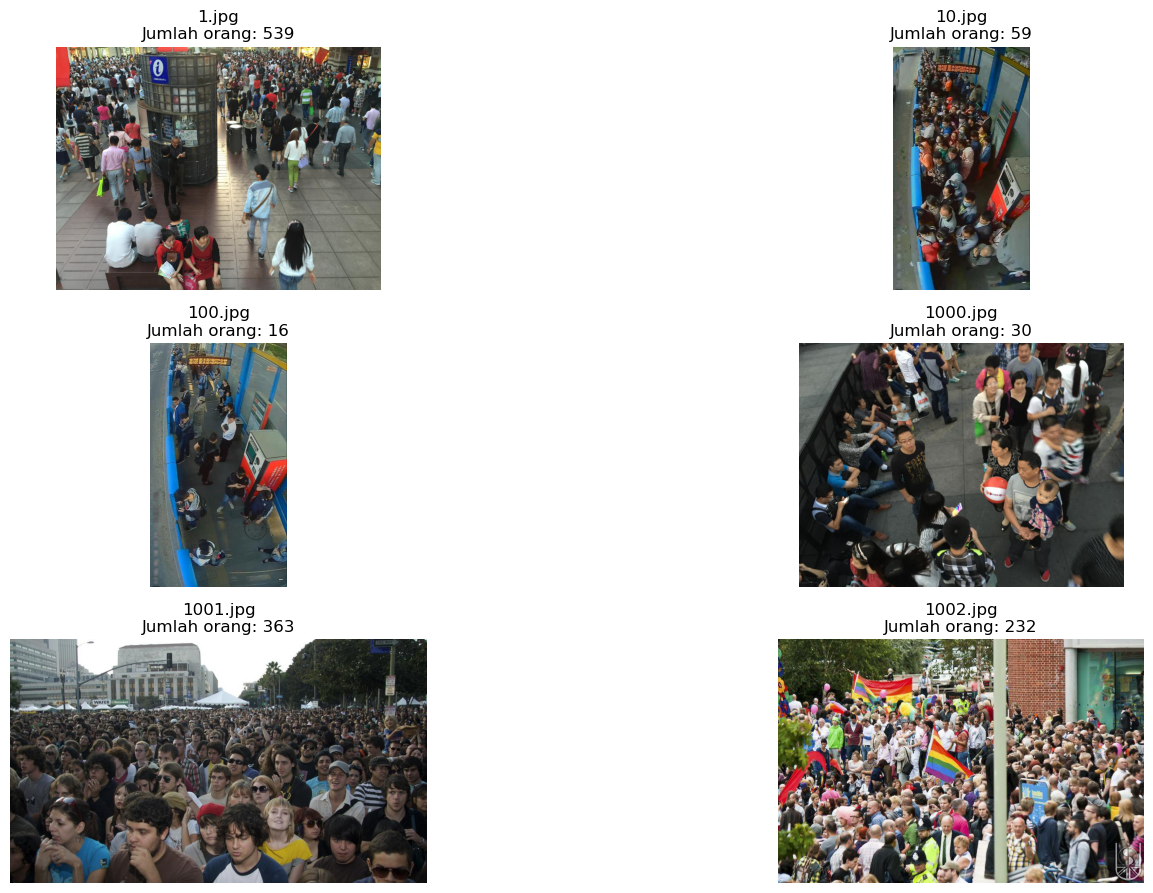

In [2]:
import os
from PIL import Image
import json
import matplotlib.pyplot as plt

image_files = sorted(os.listdir(train_path))  # sorting
n_images = len(image_files)
print(f"Jumlah gambar: {n_images}")

limit = 6
selected_files = image_files[:limit]

cols = 2
rows = (len(selected_files) // cols) + 1
plt.figure(figsize=(15, rows * 3))

for i, file in enumerate(selected_files):
    img_path = os.path.join(train_path, file)
    img = Image.open(img_path)

    label_file = os.path.join(labels_path, file.replace(".jpg", ".json"))
    count = 0  
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            data = json.load(f)
        # hitung jumlah orang
        count = len(data["points"])

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{file}\nJumlah orang: {count}")

plt.tight_layout()
plt.show()

Data transformations defined successfully!

Transformations include:
- Resize to 224x224
- Random horizontal flip (training only)
- Random crop with scale 0.8-1.0 (training only)
- Color jitter: brightness ±20%, contrast ±20% (training only)
- Tensor conversion and ImageNet normalization

Demonstrating transformations on: 1.jpg
Original image size: (1024, 768)
Transformed tensor shape: torch.Size([3, 224, 224])


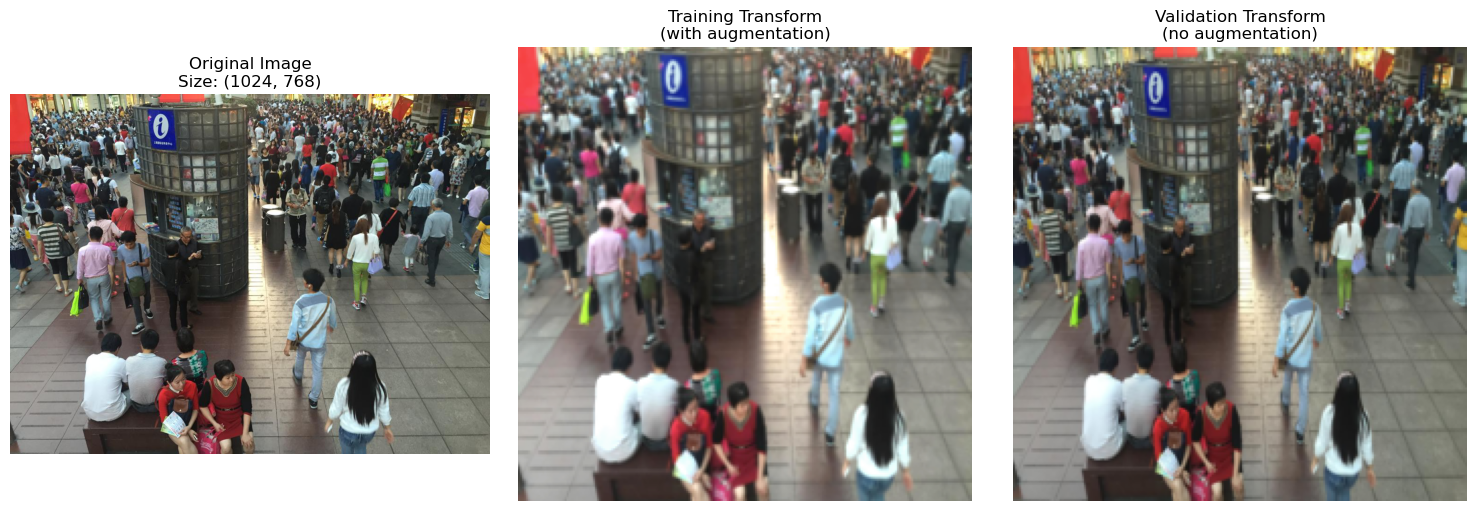

In [3]:
import torch
from torchvision import transforms


# =================================
# SECTION: DATASET TRANSFORMATIONS
# =================================

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        
        transforms.ColorJitter(
            brightness=0.2,  
            contrast=0.2,    
            saturation=0.1,  
            hue=0.05         
        ),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Data transformations defined successfully!")
print("\nTransformations include:")
print("- Resize to 224x224")
print("- Random horizontal flip (training only)")
print("- Random crop with scale 0.8-1.0 (training only)")
print("- Color jitter: brightness ±20%, contrast ±20% (training only)")
print("- Tensor conversion and ImageNet normalization")

if image_files:
    sample_img_filename = image_files[0]
    sample_img_path = os.path.join(train_path, sample_img_filename)
    sample_img = Image.open(sample_img_path).convert('RGB')
    
    print(f"\nDemonstrating transformations on: {sample_img_filename}")
    print(f"Original image size: {sample_img.size}")
    
    train_transformed = data_transforms['train'](sample_img)
    val_transformed = data_transforms['val'](sample_img)
    
    print(f"Transformed tensor shape: {train_transformed.shape}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title(f"Original Image\nSize: {sample_img.size}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    train_denorm = train_transformed * std + mean
    train_denorm = torch.clamp(train_denorm, 0, 1)
    plt.imshow(train_denorm.permute(1, 2, 0))
    plt.title("Training Transform\n(with augmentation)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    val_denorm = val_transformed * std + mean
    val_denorm = torch.clamp(val_denorm, 0, 1)
    plt.imshow(val_denorm.permute(1, 2, 0))
    plt.title("Validation Transform\n(no augmentation)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#CSRNet 


Generated density map for transformed 1.jpg
Original image size: (1024, 768)
Density map shape: (224, 224)
Number of valid points: 539
Density map sum: 535.87


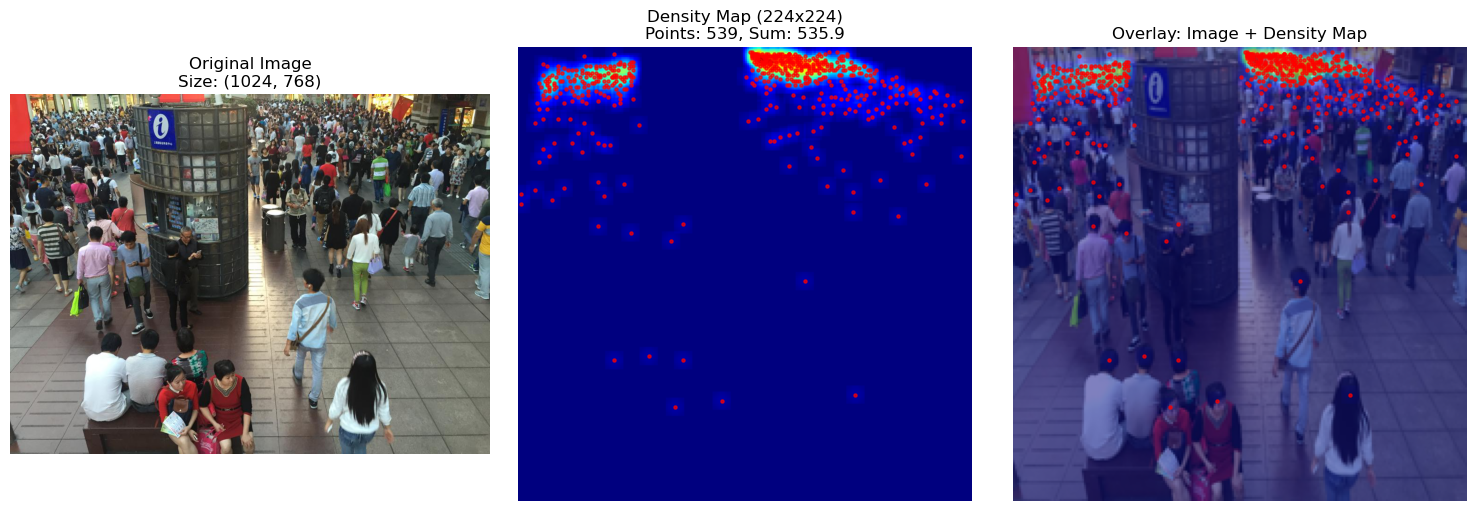

In [ ]:
import cv2
import numpy as np
import os
import json

import matplotlib.pyplot as plt

def generate_density_map_for_transformed(image_path, label_path, target_size=(224, 224), sigma=4):
    """
    Generate density map for transformed images (resized to 224x224)
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return None, []

    original_height, original_width = img.shape[:2]
    
    target_height, target_width = target_size
    density_map = np.zeros((target_height, target_width), dtype=np.float32)

    if not os.path.exists(label_path):
        print(f"Warning: Label file not found at {label_path}")
        return density_map, []

    with open(label_path, "r") as f:
        label_data = json.load(f)

    points = label_data.get("points", [])
    valid_points = []

    scale_x = target_width / original_width
    scale_y = target_height / original_height

    for point in points:
        if isinstance(point, (list, tuple)) and len(point) >= 2:
            x, y = int(point[0]), int(point[1])
        elif isinstance(point, dict) and 'x' in point and 'y' in point:
            x, y = int(point['x']), int(point['y'])
        else:
            continue

        x_scaled = int(x * scale_x)
        y_scaled = int(y * scale_y)

        if 0 <= x_scaled < target_width and 0 <= y_scaled < target_height:
            valid_points.append((x_scaled, y_scaled))
            
            kernel_size = 2 * sigma + 1
            gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
            gaussian_kernel = gaussian_kernel @ gaussian_kernel.T
            
            x_start = max(0, x_scaled - sigma)
            y_start = max(0, y_scaled - sigma)
            x_end = min(target_width, x_scaled + sigma + 1)
            y_end = min(target_height, y_scaled + sigma + 1)
            
            kx_start = x_start - (x_scaled - sigma)
            ky_start = y_start - (y_scaled - sigma)
            kx_end = kx_start + (x_end - x_start)
            ky_end = ky_start + (y_end - y_start)
            
            density_map[y_start:y_end, x_start:x_end] += gaussian_kernel[ky_start:ky_end, kx_start:kx_end]

    return density_map, valid_points

if image_files:
    sample_img_filename = image_files[0]
    sample_img_path = os.path.join(train_path, sample_img_filename)
    sample_img = Image.open(sample_img_path).convert('RGB')

    density_map_224, valid_points_224 = generate_density_map_for_transformed(
        sample_img_path, 
        sample_img_path.replace('images', 'labels').replace('.jpg', '.json'), 
        target_size=(224, 224)
    )
    
    if density_map_224 is not None:
        print(f"Generated density map for transformed {sample_img_filename}")
        print(f"Original image size: {sample_img.size}")
        print(f"Density map shape: {density_map_224.shape}")
        print(f"Number of valid points: {len(valid_points_224)}")
        print(f"Density map sum: {density_map_224.sum():.2f}")

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(sample_img)
        plt.title(f"Original Image\nSize: {sample_img.size}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(density_map_224, cmap='jet')
        if valid_points_224:
            x_coords = [p[0] for p in valid_points_224]
            y_coords = [p[1] for p in valid_points_224]
            plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
        plt.title(f"Density Map (224x224)\nPoints: {len(valid_points_224)}, Sum: {density_map_224.sum():.1f}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        # Create a resized version of the original image for overlay
        sample_img_resized = sample_img.resize((224, 224))
        plt.imshow(sample_img_resized)
        plt.imshow(density_map_224, cmap='jet', alpha=0.5)
        if valid_points_224:
            plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
        plt.title("Overlay: Image + Density Map")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Could not generate density map.")
else:
    print("No image files available. Please run the previous cells to load image data.")

In [9]:
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
import os

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class CSRNet(nn.Module):
    def __init__(self, load_weights=True, variant='standard'):
        super(CSRNet, self).__init__()
        self.variant = variant
        
        # Different configurations for each variant
        if variant == 'standard':
            self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
            self.backend_feat = [512, 512, 512, 256, 128, 64]
        elif variant == 'deeper':
            self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512]
            self.backend_feat = [512, 512, 512, 512, 256, 128, 64]
        elif variant == 'wider':
            self.frontend_feat = [96, 96, 'M', 192, 192, 'M', 384, 384, 384, 'M', 768, 768, 768]
            self.backend_feat = [768, 512, 512, 256, 128, 64]
            
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=self.frontend_feat[-1], dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights and variant == 'standard':
            # Only load VGG weights for standard variant
            vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self._initialize_weights()

            # Transfer weights from VGG-16 frontend (only for standard variant)
            vgg_features = list(vgg.features.state_dict().items())
            csrnet_frontend_state_dict = self.frontend.state_dict()
            csrnet_keys = list(csrnet_frontend_state_dict.keys())

            for i in range(min(len(vgg_features), len(csrnet_keys))):
                if vgg_features[i][1].shape == csrnet_frontend_state_dict[csrnet_keys[i]].shape:
                    csrnet_frontend_state_dict[csrnet_keys[i]] = vgg_features[i][1]

            self.frontend.load_state_dict(csrnet_frontend_state_dict)
        else:
            self._initialize_weights()

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        # Initialize all weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    d_rate = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            if dilation:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                d_rate = 2 
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) 

            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class DensityMapDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        
        if self.transform is None:
            self.transform = data_transforms['train']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(train_path, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        image = self.transform(image)
        
        label_file = os.path.join(labels_path, img_filename.replace('.jpg', '.json'))
        with open(label_file, 'r') as f:
            label_data = json.load(f)
        
        points = label_data['points']
        density_map = self._generate_density_map(image.shape[-2:], points)
        
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()
        
        density_map = F.interpolate(density_map.unsqueeze(0), size=(28, 28), mode='bilinear', align_corners=False).squeeze(0)
        
        return image, density_map
    
    def _generate_density_map(self, img_size, points):
        """Generate Gaussian density map from point annotations"""
        h, w = img_size
        density_map = np.zeros((h, w), dtype=np.float32)
        
        if len(points) == 0:
            return density_map
            
        for point in points:
            x = int(point['x'] * w / 1024)  
            y = int(point['y'] * h / 768)
            
            if 0 <= x < w and 0 <= y < h:
                sigma = 3  
                kernel_size = int(3 * sigma)
                
                x_min = max(0, x - kernel_size)
                x_max = min(w, x + kernel_size + 1)
                y_min = max(0, y - kernel_size)
                y_max = min(h, y + kernel_size + 1)
                
                for i in range(y_min, y_max):
                    for j in range(x_min, x_max):
                        dist_sq = (i - y) ** 2 + (j - x) ** 2
                        density_map[i, j] += np.exp(-dist_sq / (2 * sigma ** 2))
        
        return density_map

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize 3 different model variants
model_variants = ['standard', 'deeper', 'wider']
models_dict = {}
optimizers_dict = {}
schedulers_dict = {}
best_val_losses = {}
train_losses_dict = {}
val_losses_dict = {}

print("\n=== INITIALIZING 3 MODEL TYPE ===")
for variant in model_variants:
    print(f"\nInitializing {variant} CSRNet model...")
    model = CSRNet(load_weights=True, variant=variant).to(device)
    models_dict[variant] = model
    
    # Different learning rates for different variants
    lr_dict = {'standard': 1e-5, 'deeper': 5e-6, 'wider': 8e-6}
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_dict[variant], weight_decay=1e-4)
    optimizers_dict[variant] = optimizer
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    schedulers_dict[variant] = scheduler
    
    best_val_losses[variant] = float('inf')
    train_losses_dict[variant] = []
    val_losses_dict[variant] = []
    
    print(f"{variant.capitalize()} CSRNet model initialized")

# Dataset setup
train_size = int(0.8 * len(image_files))
val_size = len(image_files) - train_size

train_files = image_files[:train_size]
val_files = image_files[train_size:]

print(f"\nTraining set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")

train_dataset = DensityMapDataset(train_files, data_transforms['train'])
val_dataset = DensityMapDataset(val_files, data_transforms['val'])

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Training parameters
criterion = nn.MSELoss()
num_epochs = 40  # Reduced epochs since we're training 3 models

print("\n" + "="*80)
print("STARTING ENSEMBLE TRAINING WITH 3 CSRNET VARIANTS")
print("="*80)

for epoch in range(num_epochs):
    print(f"\n{'='*20} EPOCH [{epoch+1}/{num_epochs}] {'='*20}")
    
    # Train each model variant
    for variant in model_variants:
        print(f"\nTraining {variant} model...")
        model = models_dict[variant]
        optimizer = optimizers_dict[variant]
        
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for batch_idx, (images, density_maps) in enumerate(tqdm(train_loader, desc=f"Training {variant}")):
            images = images.to(device)
            density_maps = density_maps.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, density_maps)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        train_losses_dict[variant].append(avg_train_loss)
        
        # Validation for this model
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for images, density_maps in tqdm(val_loader, desc=f"Validating {variant}"):
                images = images.to(device)
                density_maps = density_maps.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, density_maps)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_losses_dict[variant].append(avg_val_loss)
        
        print(f"{variant.capitalize()} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save best model for this variant
        if avg_val_loss < best_val_losses[variant]:
            best_val_losses[variant] = avg_val_loss
            torch.save(model.state_dict(), f'PenyelamHandal_{variant}.pth')
            print(f"  New best {variant} model saved! Val Loss: {avg_val_loss:.4f}")
        
        # Update scheduler
        schedulers_dict[variant].step()
    
    # Plot progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize=(15, 5))
        
        colors = {'standard': 'blue', 'deeper': 'red', 'wider': 'green'}
        
        for i, variant in enumerate(model_variants):
            plt.subplot(1, 3, i + 1)
            plt.plot(range(1, epoch + 2), train_losses_dict[variant], 
                    color=colors[variant], linestyle='-', label='Training Loss')
            plt.plot(range(1, epoch + 2), val_losses_dict[variant], 
                    color=colors[variant], linestyle='--', label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'{variant.capitalize()} Model Progress')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

print("\n" + "="*80)
print("ENSEMBLE TRAINING COMPLETED!")
print("="*80)

# Print results for all models
for variant in model_variants:
    print(f"{variant.capitalize()} model - Best validation loss: {best_val_losses[variant]:.4f}")

# Final comprehensive plot
plt.figure(figsize=(15, 10))

colors = {'standard': 'blue', 'deeper': 'red', 'wider': 'green'}

# Training losses
plt.subplot(2, 2, 1)
for variant in model_variants:
    plt.plot(range(1, num_epochs + 1), train_losses_dict[variant], 
            color=colors[variant], label=f'{variant.capitalize()}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Validation losses
plt.subplot(2, 2, 2)
for variant in model_variants:
    plt.plot(range(1, num_epochs + 1), val_losses_dict[variant], 
            color=colors[variant], label=f'{variant.capitalize()}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

# Best performance comparison
plt.subplot(2, 2, 3)
variants_list = list(best_val_losses.keys())
best_losses_list = list(best_val_losses.values())
bars = plt.bar(variants_list, best_losses_list, color=['blue', 'red', 'green'])
plt.ylabel('Best Validation Loss')
plt.title('Best Performance Comparison')
plt.grid(True, axis='y')
for bar, loss in zip(bars, best_losses_list):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{loss:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n--- Testing ensemble model on sample images ---")
# Test all models on sample images
sample_indices = [0, 1, 2]
plt.figure(figsize=(18, 12))

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        image, gt_density = train_dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        # Get predictions from all models
        predictions = {}
        for variant in model_variants:
            model = models_dict[variant]
            model.eval()
            pred = model(image_tensor).cpu().squeeze()
            predictions[variant] = pred
        
        # Ensemble prediction (average)
        ensemble_pred = torch.mean(torch.stack(list(predictions.values())), dim=0)
        
        # Load original image
        original_img = Image.open(os.path.join(train_path, train_files[idx]))
        
        # Calculate counts
        gt_count = gt_density.sum().item()
        ensemble_count = ensemble_pred.sum().item()
        
        # Display results
        plt.subplot(3, 6, i*6 + 1)
        plt.imshow(original_img)
        plt.title(f"Original\n{train_files[idx]}")
        plt.axis('off')
        
        plt.subplot(3, 6, i*6 + 2)
        plt.imshow(gt_density.squeeze(), cmap='jet')
        plt.title(f"Ground Truth\nCount: {gt_count:.1f}")
        plt.axis('off')
        
        # Show individual model predictions
        for j, variant in enumerate(model_variants):
            pred_count = predictions[variant].sum().item()
            plt.subplot(3, 6, i*6 + 3 + j)
            plt.imshow(predictions[variant], cmap='jet')
            plt.title(f"{variant.capitalize()}\nCount: {pred_count:.1f}")
            plt.axis('off')
        
        plt.subplot(3, 6, i*6 + 6)
        plt.imshow(ensemble_pred, cmap='jet')
        plt.title(f"Ensemble\nCount: {ensemble_count:.1f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("Ensemble training complete! All 3 models ready for inference.")
print(f"Model files saved:")
for variant in model_variants:
    print(f"- PenyelamHandal_{variant}.pth")

Using device: cuda

=== INITIALIZING 3 MODEL VARIANTS ===

Initializing standard CSRNet model...
Standard CSRNet model initialized

Initializing deeper CSRNet model...
Standard CSRNet model initialized

Initializing deeper CSRNet model...
Deeper CSRNet model initialized

Initializing wider CSRNet model...
Deeper CSRNet model initialized

Initializing wider CSRNet model...
Wider CSRNet model initialized

Training set: 1520 images
Validation set: 380 images

STARTING ENSEMBLE TRAINING WITH 3 CSRNET VARIANTS

==================== EPOCH [1/40] ====================

Training standard model...
Wider CSRNet model initialized

Training set: 1520 images
Validation set: 380 images

STARTING ENSEMBLE TRAINING WITH 3 CSRNET VARIANTS

==================== EPOCH [1/40] ====================

Training standard model...


Training standard:  24%|██▍       | 92/380 [01:34<04:55,  1.03s/it]



KeyboardInterrupt: 

In [10]:
# ========================================
# SECTION: FINAL EVALUATION WITH DATATEST
# =======================================

print("--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---")

def calculate_mae(predictions, ground_truth):
    """Calculate Mean Absolute Error"""
    return np.mean(np.abs(predictions - ground_truth))

def calculate_rmse(predictions, ground_truth):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(np.mean((predictions - ground_truth) ** 2))

def calculate_mape(predictions, ground_truth):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((predictions - ground_truth) / np.maximum(ground_truth, 1)) * 100)

def density_category_analysis(predictions, ground_truth, low_thresh=5, high_thresh=20):
    """Analyze errors by density categories"""
    low_density_mask = ground_truth <= low_thresh
    medium_density_mask = (ground_truth > low_thresh) & (ground_truth <= high_thresh)
    high_density_mask = ground_truth > high_thresh
    
    results = {}
    
    if np.any(low_density_mask):
        low_pred = predictions[low_density_mask]
        low_gt = ground_truth[low_density_mask]
        results['low'] = {
            'count': len(low_pred),
            'mae': calculate_mae(low_pred, low_gt),
            'rmse': calculate_rmse(low_pred, low_gt),
            'mape': calculate_mape(low_pred, low_gt)
        }
    
    if np.any(medium_density_mask):
        med_pred = predictions[medium_density_mask]
        med_gt = ground_truth[medium_density_mask]
        results['medium'] = {
            'count': len(med_pred),
            'mae': calculate_mae(med_pred, med_gt),
            'rmse': calculate_rmse(med_pred, med_gt),
            'mape': calculate_mape(med_pred, med_gt)
        }
    
    if np.any(high_density_mask):
        high_pred = predictions[high_density_mask]
        high_gt = ground_truth[high_density_mask]
        results['high'] = {
            'count': len(high_pred),
            'mae': calculate_mae(high_pred, high_gt),
            'rmse': calculate_rmse(high_pred, high_gt),
            'mape': calculate_mape(high_pred, high_gt)
        }
    
    return results

print("Loading best trained model...")
model.load_state_dict(torch.load('PenyelamHandal.pth'))
model.eval()

eval_size = min(500, len(image_files))  
eval_indices = np.random.choice(len(image_files), eval_size, replace=False)
eval_image_files = [image_files[i] for i in eval_indices]

print(f"Evaluating model on {len(eval_image_files)} images...")

all_predictions = []
all_ground_truth = []
all_filenames = []

with torch.no_grad():
    for img_file in tqdm(eval_image_files, desc="Evaluating"):
        img_path = os.path.join(train_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
        
        output = model(img_tensor)
        predicted_count = torch.sum(output).item()
        
        label_path = os.path.join(labels_path, img_file.replace('.jpg', '.json'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_data = json.load(f)
            gt_count = len(label_data.get('points', []))
            
            all_predictions.append(predicted_count)
            all_ground_truth.append(gt_count)
            all_filenames.append(img_file)

predictions_np = np.array(all_predictions)
ground_truth_np = np.array(all_ground_truth)

overall_mae = calculate_mae(predictions_np, ground_truth_np)
overall_rmse = calculate_rmse(predictions_np, ground_truth_np)
overall_mape = calculate_mape(predictions_np, ground_truth_np)

density_analysis = density_category_analysis(predictions_np, ground_truth_np, 
                                           low_thresh=10, high_thresh=50)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION RESULTS")
print("="*80)

print(f"Dataset size: {len(all_predictions)} images")
print(f"Ground truth range: {ground_truth_np.min()} - {ground_truth_np.max()}")
print(f"Predictions range: {predictions_np.min():.1f} - {predictions_np.max():.1f}")

print(f"\nOVERALL METRICS:")
print(f"MAE (Mean Absolute Error): {overall_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {overall_rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {overall_mape:.2f}%")

print(f"\nDENSITY CATEGORY ANALYSIS:")
for category, metrics in density_analysis.items():
    print(f"{category.upper()} DENSITY (n={metrics['count']}):")
    print(f"  MAE: {metrics['mae']:.2f}")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")

correlation = np.corrcoef(predictions_np, ground_truth_np)[0, 1]
print(f"\nCORRELATION ANALYSIS:")
print(f"Pearson correlation coefficient: {correlation:.3f}")

errors = predictions_np - ground_truth_np
print(f"\nERROR DISTRIBUTION:")
print(f"Mean error (bias): {np.mean(errors):.2f}")
print(f"Std error: {np.std(errors):.2f}")
print(f"Median error: {np.median(errors):.2f}")


print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"Detailed results saved to 'final_evaluation_results.json'")
print(f"Model shows {'good' if overall_mae < 5 else 'moderate' if overall_mae < 10 else 'poor'} performance with MAE of {overall_mae:.2f}")

--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---
Loading best trained model...
Evaluating model on 500 images...


Evaluating: 100%|██████████| 500/500 [00:24<00:00, 20.22it/s]


COMPREHENSIVE MODEL EVALUATION RESULTS
Dataset size: 500 images
Ground truth range: 2 - 2164
Predictions range: 14.3 - 2116.0

OVERALL METRICS:
MAE (Mean Absolute Error): 63.06
RMSE (Root Mean Squared Error): 109.68
MAPE (Mean Absolute Percentage Error): 141.82%

DENSITY CATEGORY ANALYSIS:
LOW DENSITY (n=129):
  MAE: 16.34
  RMSE: 17.05
  MAPE: 304.46%
MEDIUM DENSITY (n=158):
  MAE: 26.33
  RMSE: 33.95
  MAPE: 119.02%
HIGH DENSITY (n=213):
  MAE: 118.59
  RMSE: 164.95
  MAPE: 60.24%

CORRELATION ANALYSIS:
Pearson correlation coefficient: 0.951

ERROR DISTRIBUTION:
Mean error (bias): 49.10
Std error: 98.08
Median error: 23.87

EVALUATION COMPLETE!
Detailed results saved to 'final_evaluation_results.json'
Model shows poor performance with MAE of 63.06


--- TESTING MODEL ON TEST DATA ---
Found 500 test images
Loading best trained model...
Processing test images...


Testing: 100%|██████████| 500/500 [00:19<00:00, 25.43it/s]


Successfully processed 500 test images

Test Predictions Statistics:
Min prediction: 15.38
Max prediction: 2034.58
Mean prediction: 181.85
Median prediction: 68.45
Std prediction: 264.28

--- Sample Test Predictions ---


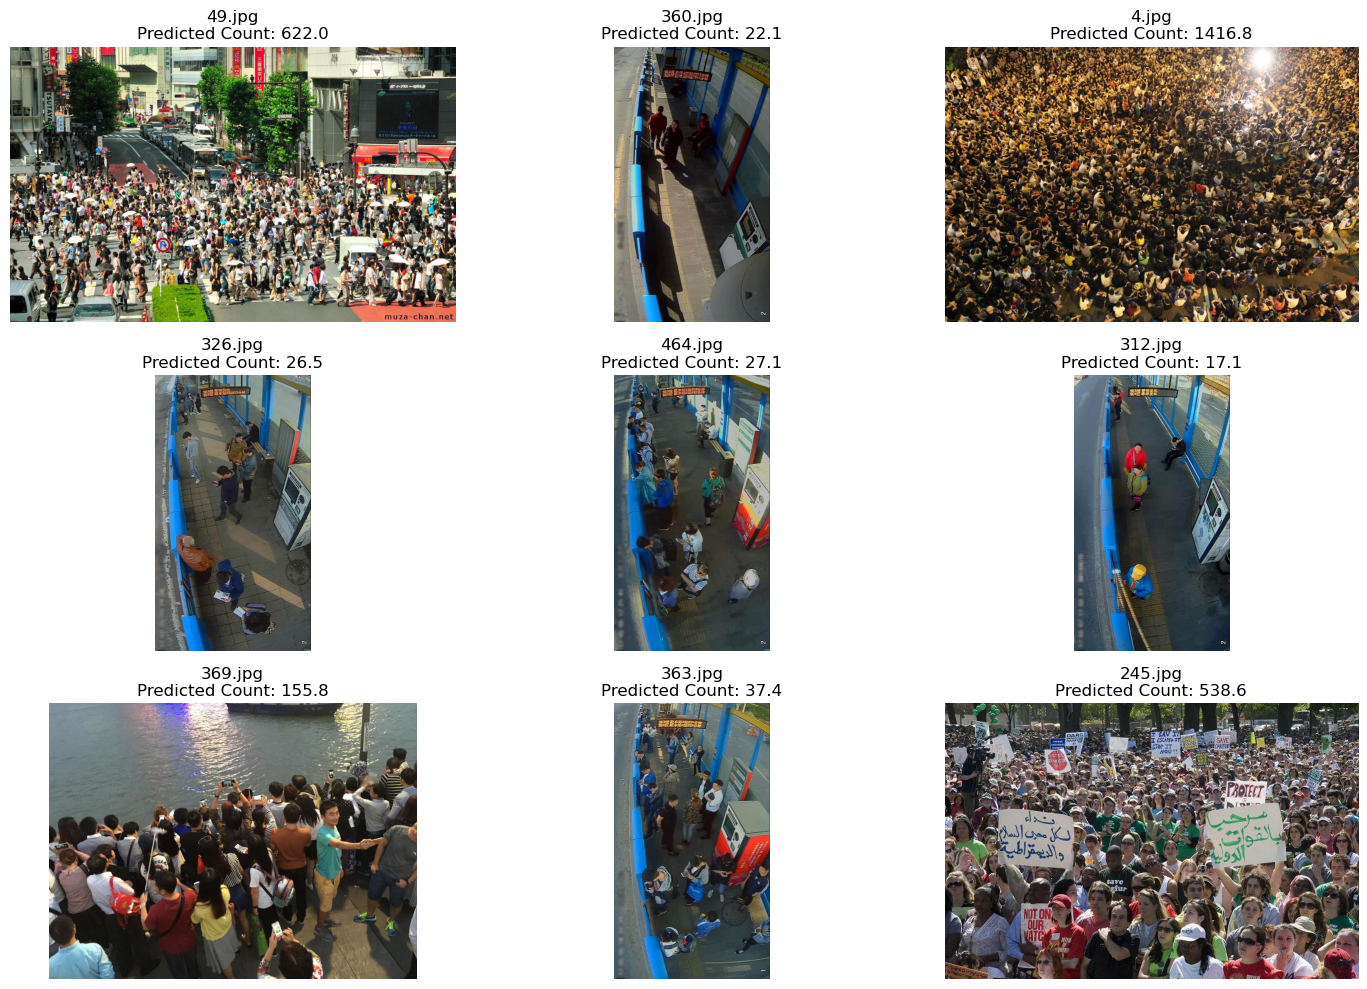


--- Creating Submission File ---
Submission file saved as: test_predictions.csv
Contains 500 predictions

First 10 rows of submission:
  filename  prediction
0    1.jpg          39
1   10.jpg         147
2  100.jpg         293
3  101.jpg          22
4  102.jpg         763
5  103.jpg          33
6  104.jpg          59
7  105.jpg          23
8  106.jpg         671
9  107.jpg          25

Prediction Categories:
Very Low (0-5): 0 images (0.0%)
Low (6-20): 49 images (9.8%)
Medium (21-50): 187 images (37.4%)
High (51-100): 37 images (7.4%)
Very High (>100): 227 images (45.4%)

Comparison with Training Data:
Training mean: 135.93
Test mean: 181.85
Training median: 25.00
Test median: 68.45

TEST PREDICTION COMPLETE!
Files created:
- test_predictions.csv (final submission)
- detailed_test_predictions.csv (detailed predictions)
Ready for submission!


In [8]:
import pandas as pd

# =================================
# SECTION: TEST MODEL ON TEST DATA
# =================================

print("--- TESTING MODEL ON TEST DATA ---")

test_path = "penyisihan-hology-8-0-2025-data-mining/test/images"

if not os.path.exists(test_path):
    print(f"Test directory not found at: {test_path}")
    print("Please check the path or ensure test data is available.")
else:
    test_image_files = sorted(os.listdir(test_path))
    print(f"Found {len(test_image_files)} test images")
    
    print("Loading best trained model...")
    model.load_state_dict(torch.load('PenyelamHandal.pth'))
    model.eval()
    
    test_predictions = []
    test_filenames = []
    
    print("Processing test images...")
    
    with torch.no_grad():
        for img_file in tqdm(test_image_files, desc="Testing"):
            try:
                img_path = os.path.join(test_path, img_file)
                img = Image.open(img_path).convert('RGB')
                
                img_tensor = data_transforms['test'](img).unsqueeze(0).to(device)
                
                output = model(img_tensor)
                predicted_count = torch.sum(output).item()
                
                predicted_count = max(0, predicted_count)
                
                test_predictions.append(predicted_count)
                test_filenames.append(img_file)
                
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    print(f"Successfully processed {len(test_predictions)} test images")
    
    test_predictions_np = np.array(test_predictions)
    print(f"\nTest Predictions Statistics:")
    print(f"Min prediction: {test_predictions_np.min():.2f}")
    print(f"Max prediction: {test_predictions_np.max():.2f}")
    print(f"Mean prediction: {test_predictions_np.mean():.2f}")
    print(f"Median prediction: {np.median(test_predictions_np):.2f}")
    print(f"Std prediction: {test_predictions_np.std():.2f}")
    
    print("\n--- Sample Test Predictions ---")
    
    n_samples = min(9, len(test_predictions))
    sample_indices = np.random.choice(len(test_predictions), n_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        img_file = test_filenames[idx]
        pred_count = test_predictions[idx]
        
        img_path = os.path.join(test_path, img_file)
        img = Image.open(img_path)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'{img_file}\nPredicted Count: {pred_count:.1f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- Creating Submission File ---")
    
    submission_data = []
    for filename, prediction in zip(test_filenames, test_predictions):
        rounded_prediction = max(0, round(prediction))
        submission_data.append({
            'filename': filename,
            'prediction': rounded_prediction
        })
    
    submission_df = pd.DataFrame(submission_data)
    submission_file = 'test_predictions.csv'
    submission_df.to_csv(submission_file, index=False)
    
    print(f"Submission file saved as: {submission_file}")
    print(f"Contains {len(submission_df)} predictions")
    
    print("\nFirst 10 rows of submission:")
    print(submission_df.head(10))
    
    detailed_submission = []
    for filename, prediction in zip(test_filenames, test_predictions):
        detailed_submission.append({
            'filename': filename,
            'raw_prediction': prediction,
            'rounded_prediction': max(0, round(prediction))
        })
    
    detailed_df = pd.DataFrame(detailed_submission)
    detailed_file = 'detailed_test_predictions.csv'
    detailed_df.to_csv(detailed_file, index=False)
    
    
    
    categories = {
        'Very Low (0-5)': np.sum((test_predictions_np >= 0) & (test_predictions_np <= 5)),
        'Low (6-20)': np.sum((test_predictions_np > 5) & (test_predictions_np <= 20)),
        'Medium (21-50)': np.sum((test_predictions_np > 20) & (test_predictions_np <= 50)),
        'High (51-100)': np.sum((test_predictions_np > 50) & (test_predictions_np <= 100)),
        'Very High (>100)': np.sum(test_predictions_np > 100)
    }
    
    print(f"\nPrediction Categories:")
    for category, count in categories.items():
        percentage = (count / len(test_predictions_np)) * 100
        print(f"{category}: {count} images ({percentage:.1f}%)")
    
    if len(all_ground_truth) > 0:
        print(f"\nComparison with Training Data:")
        print(f"Training mean: {np.mean(all_ground_truth):.2f}")
        print(f"Test mean: {test_predictions_np.mean():.2f}")
        print(f"Training median: {np.median(all_ground_truth):.2f}")
        print(f"Test median: {np.median(test_predictions_np):.2f}")
    
    
    print("\n" + "="*60)
    print("TEST PREDICTION COMPLETE!")
    print("="*60)
    print(f"Files created:")
    print(f"- {submission_file} (final submission)")
    print(f"- {detailed_file} (detailed predictions)")
    print(f"Ready for submission!")